# Quantium Data Analysis

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

In [2]:
#Load datasets
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

## 1. Data Cleaning

### 1.1. Cleaning transaction data 

In [3]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [5]:
#Change dtype to save memory
transaction_data['TOT_SALES'] = transaction_data['TOT_SALES'].astype('float32') #Change float64 to float32

int64 =  transaction_data.select_dtypes(include=['int64']).columns.tolist() 
transaction_data[int64] = transaction_data[int64].astype('int32') #Change int64 to int32

transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].astype('category')

In [6]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   DATE            264836 non-null  int32   
 1   STORE_NBR       264836 non-null  int32   
 2   LYLTY_CARD_NBR  264836 non-null  int32   
 3   TXN_ID          264836 non-null  int32   
 4   PROD_NBR        264836 non-null  int32   
 5   PROD_NAME       264836 non-null  category
 6   PROD_QTY        264836 non-null  int32   
 7   TOT_SALES       264836 non-null  float32 
dtypes: category(1), float32(1), int32(6)
memory usage: 7.3 MB


Memory usage from 16.2+ MB change to 7.3 MB

In [7]:
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.000000,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,43464.036260,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.302778
std,105.389282,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083583
min,43282.000000,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,43646.000000,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


The maximum of PROD_QTY, TOT_SALES are outstanding. Let's take a look

In [8]:
transaction_data.loc[transaction_data['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,43331,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,43605,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are 2 transactions where 200 packets of chips are purchased in one transaction by the same customer. Let examine other transactions by this customer

In [9]:
transaction_data.loc[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,43331,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,43605,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There is no other transactions by this customer. So it is not an ordinary retail customer. I will remove this customer from further analysis

In [10]:
transaction_data = transaction_data.drop(transaction_data[transaction_data.LYLTY_CARD_NBR == 226000].index)
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264834.000000,264834.000000,2.648340e+05,2.648340e+05,264834.000000,264834.000000,264834.000000
mean,43464.036230,135.079423,1.355488e+05,1.351576e+05,56.583554,1.905813,7.297929
std,105.389007,76.784063,8.057990e+04,7.813292e+04,32.826444,0.343436,2.527142
min,43282.000000,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.000000,7.002100e+04,6.760050e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.000000,1.303570e+05,1.351365e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.000000,2.030940e+05,2.026998e+05,85.000000,2.000000,9.200000
max,43646.000000,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


Now check unique values of each column

In [11]:
for column in transaction_data.columns.to_list():
    print("No of unique values in column " + column + " are: " + str(len(np.unique(transaction_data[column]))))

No of unique values in column DATE are: 364
No of unique values in column STORE_NBR are: 272
No of unique values in column LYLTY_CARD_NBR are: 72636
No of unique values in column TXN_ID are: 263125
No of unique values in column PROD_NBR are: 114
No of unique values in column PROD_NAME are: 114
No of unique values in column PROD_QTY are: 5
No of unique values in column TOT_SALES are: 111


In [12]:
transaction_data.isnull().sum().sum()

0

No null values! Now check if I am looking at the right products by examining PROD_NAME

In [13]:
np.unique(transaction_data['PROD_NAME'])

array(['Burger Rings 220g', 'CCs Nacho Cheese    175g',
       'CCs Original 175g', 'CCs Tasty Cheese    175g',
       'Cheetos Chs & Bacon Balls 190g', 'Cheetos Puffs 165g',
       'Cheezels Cheese 330g', 'Cheezels Cheese Box 125g',
       'Cobs Popd Sea Salt  Chips 110g',
       'Cobs Popd Sour Crm  &Chives Chips 110g',
       'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g',
       'Dorito Corn Chp     Supreme 380g',
       'Doritos Cheese      Supreme 330g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Doritos Corn Chips  Cheese Supreme 170g',
       'Doritos Corn Chips  Nacho Cheese 170g',
       'Doritos Corn Chips  Original 170g', 'Doritos Mexicana    170g',
       'Doritos Salsa       Medium 300g', 'Doritos Salsa Mild  300g',
       'French Fries Potato Chips 175g',
       'Grain Waves         Sweet Chilli 210g',
       'Grain Waves Sour    Cream&Chives 210G',
       'GrnWves Plus Btroot & Chilli Jam 180g',
       'Infuzi

As the Client is the Category of Manager for Chips, I should only focus on the chips product. The salsa products should be removed.

In [14]:
discard = ["Salsa"]
transaction_data = transaction_data[transaction_data['PROD_NAME'].apply(lambda x: 'Salsa' not in x)]
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   DATE            246740 non-null  int32   
 1   STORE_NBR       246740 non-null  int32   
 2   LYLTY_CARD_NBR  246740 non-null  int32   
 3   TXN_ID          246740 non-null  int32   
 4   PROD_NBR        246740 non-null  int32   
 5   PROD_NAME       246740 non-null  category
 6   PROD_QTY        246740 non-null  int32   
 7   TOT_SALES       246740 non-null  float32 
dtypes: category(1), float32(1), int32(6)
memory usage: 8.7 MB


Now let's create an other attribute to get pack size from PROD_NAME

In [15]:
transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].astype(str)
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.lower().str.extract(r'(\d+)') #extract with gram
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


Now run the summary to check the pack size gram!

In [16]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            246740 non-null  int32  
 1   STORE_NBR       246740 non-null  int32  
 2   LYLTY_CARD_NBR  246740 non-null  int32  
 3   TXN_ID          246740 non-null  int32  
 4   PROD_NBR        246740 non-null  int32  
 5   PROD_NAME       246740 non-null  object 
 6   PROD_QTY        246740 non-null  int32  
 7   TOT_SALES       246740 non-null  float32
 8   PACK_SIZE       246740 non-null  object 
dtypes: float32(1), int32(6), object(2)
memory usage: 12.2+ MB


In [17]:
#Change pack_size to float16
transaction_data['PACK_SIZE'] = transaction_data['PACK_SIZE'].astype('float16') #it is not numeric

Let's count the number of transactions by pack size

In [18]:
size_freq = Counter(transaction_data['PACK_SIZE'])
size_freq

Counter({175.0: 66390,
         170.0: 19983,
         150.0: 40203,
         330.0: 12540,
         210.0: 6272,
         270.0: 6285,
         220.0: 1564,
         125.0: 1454,
         110.0: 22387,
         134.0: 25102,
         380.0: 6416,
         180.0: 1468,
         165.0: 15297,
         135.0: 3257,
         250.0: 3169,
         200.0: 4473,
         160.0: 2970,
         190.0: 2995,
         90.0: 3008,
         70.0: 1507})

It looks reasonable. Now let's create the brand_name column by extracting the first word

In [19]:
transaction_data['BRAND_NAME'] = transaction_data['PROD_NAME'].str.partition()[0]
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle


In [20]:
#Check brands
np.unique(transaction_data['BRAND_NAME'])

array(['Burger', 'CCs', 'Cheetos', 'Cheezels', 'Cobs', 'Dorito',
       'Doritos', 'French', 'Grain', 'GrnWves', 'Infuzions', 'Infzns',
       'Kettle', 'NCC', 'Natural', 'Pringles', 'RRD', 'Red', 'Smith',
       'Smiths', 'Snbts', 'Sunbites', 'Thins', 'Tostitos', 'Twisties',
       'Tyrrells', 'WW', 'Woolworths'], dtype=object)

Some brand names look like they are of the same brands:
- Dorito and Doritos, which are both Doritos
- Grain and GrnWves, which are both Grainwaves
- Red and RRD, which are both Red Rock Deli Chips
- Infuzions and Infzns, which are both Infuzions Corn Crunchers
- Smith and Smiths, which are both Smiths
- Snbts and Sunbites, which are both Sunbites
- WW and Woolworths, which are both Woolworths
- NCC and Natural

In [21]:
value_replaced = ['Dorito','Grain','GrnWves','RRD','Infzns','Smith','Snbts','WW','NCC']
new_values = ['Doritos','Grainwaves','Grainwaves','Red','Infuzions','Smiths','Sunbites','Woolworths','Natural']
for i in range(len(value_replaced)):
    transaction_data['BRAND_NAME'].replace(value_replaced[i],new_values[i],inplace = True)
np.unique(transaction_data['BRAND_NAME'])

array(['Burger', 'CCs', 'Cheetos', 'Cheezels', 'Cobs', 'Doritos',
       'French', 'Grainwaves', 'Infuzions', 'Kettle', 'Natural',
       'Pringles', 'Red', 'Smiths', 'Sunbites', 'Thins', 'Tostitos',
       'Twisties', 'Tyrrells', 'Woolworths'], dtype=object)

Now let's move to customer data!

### 1.2. Cleaning customer data 

In [22]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [23]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
customer_data['LYLTY_CARD_NBR'].astype('int16')
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


No null values! Let's examinate unique values

In [25]:
np.unique(customer_data['LIFESTAGE'])

array(['MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'OLDER SINGLES/COUPLES', 'RETIREES', 'YOUNG FAMILIES',
       'YOUNG SINGLES/COUPLES'], dtype=object)

In [26]:
np.unique(customer_data['PREMIUM_CUSTOMER'])

array(['Budget', 'Mainstream', 'Premium'], dtype=object)

No things abnormal! Now merge the two data for analysis

In [27]:
merge_data = pd.merge(transaction_data, customer_data, how = 'left')
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  int32  
 1   STORE_NBR         246740 non-null  int32  
 2   LYLTY_CARD_NBR    246740 non-null  int32  
 3   TXN_ID            246740 non-null  int32  
 4   PROD_NBR          246740 non-null  int32  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int32  
 7   TOT_SALES         246740 non-null  float32
 8   PACK_SIZE         246740 non-null  float16
 9   BRAND_NAME        246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
dtypes: float16(1), float32(1), int32(6), object(4)
memory usage: 16.5+ MB


As the number of data records in the merge_data is the same as the transaction_data, we can be sure that no duplicates were created. This is left join.

Also, there is no nulls, so all customers in the transaction data has been accounted for in the customer dataset.

Let's do the exploratory data analysis! :) 

## 2. EDA

<AxesSubplot:xlabel='PREMIUM_CUSTOMER', ylabel='TOT_SALES'>

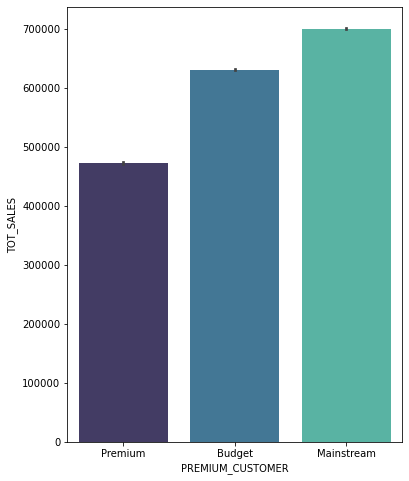

In [28]:
fig,ax = plt.subplots(figsize = (6,8))
sns.barplot(x = 'PREMIUM_CUSTOMER', y = 'TOT_SALES', data = merge_data, palette = 'mako', estimator = np.sum )

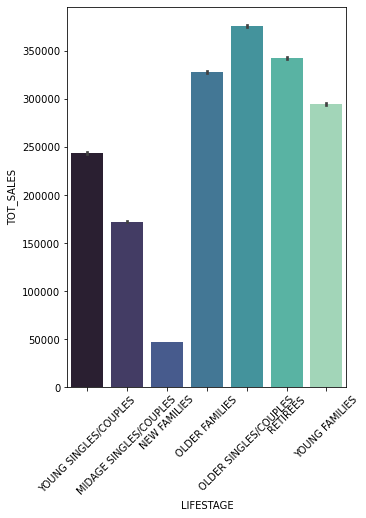

In [29]:
fig,ax = plt.subplots(figsize = (5,7))
sns.barplot(x = 'LIFESTAGE', y = 'TOT_SALES', data = merge_data, palette = 'mako', estimator = np.sum)
plt.xticks(rotation=45)
plt.show()

<Figure size 1080x720 with 0 Axes>

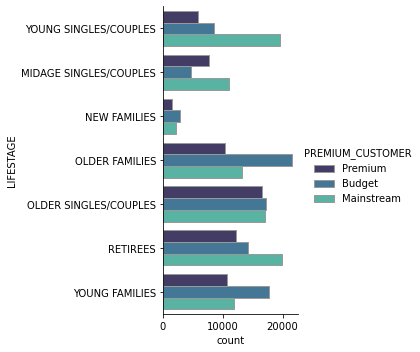

In [30]:
plt.figure(figsize=(15, 10))
ax = sns.catplot(y="LIFESTAGE", hue="PREMIUM_CUSTOMER", kind="count",
            palette="mako", edgecolor=".6",
            data=merge_data)

Most transactions in Young singles/couples, midage singles/couples, and retirees stage are from mainstream while in young families and older families stage transactions, most of them are budget customers.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'YOUNG SINGLES/COUPLES'),
  Text(1, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(2, 0, 'NEW FAMILIES'),
  Text(3, 0, 'OLDER FAMILIES'),
  Text(4, 0, 'OLDER SINGLES/COUPLES'),
  Text(5, 0, 'RETIREES'),
  Text(6, 0, 'YOUNG FAMILIES')])

<Figure size 864x720 with 0 Axes>

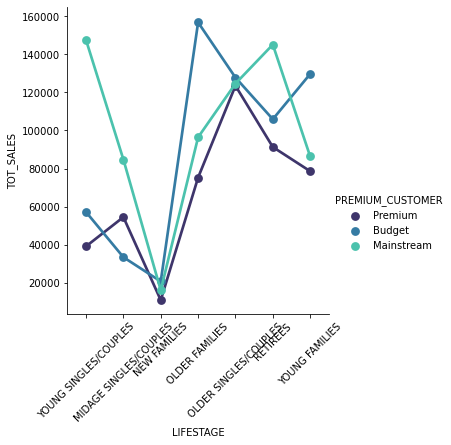

In [31]:
plt.figure(figsize=(12, 10))
ax = sns.catplot(x='LIFESTAGE',y = 'TOT_SALES',hue = 'PREMIUM_CUSTOMER',palette = 'mako',kind = 'point',data=merge_data, estimator = np.sum)
plt.xticks(rotation=45)

Sales are coming mainly from Mainstream - young singles/couples, Mainstream - retirees, Budget - older families, and Budget - young families.

High sales may also be driven by more units of chips bought per customer. Let's take a look

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'YOUNG SINGLES/COUPLES'),
  Text(1, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(2, 0, 'NEW FAMILIES'),
  Text(3, 0, 'OLDER FAMILIES'),
  Text(4, 0, 'OLDER SINGLES/COUPLES'),
  Text(5, 0, 'RETIREES'),
  Text(6, 0, 'YOUNG FAMILIES')])

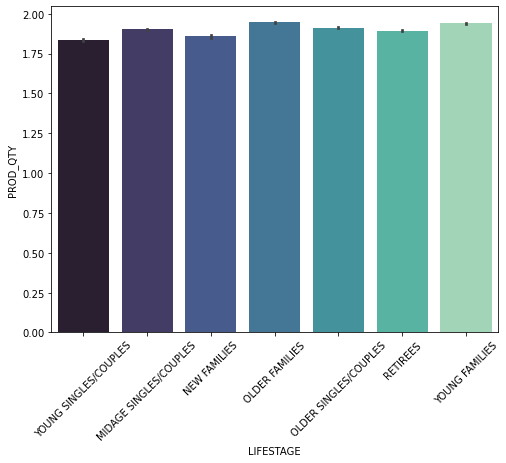

In [32]:
fig,ax = plt.subplots(figsize = (8,6))
sns.barplot(x = 'LIFESTAGE', y = 'PROD_QTY', data = merge_data, palette = 'mako', estimator = np.mean)
plt.xticks(rotation=45)

On average, older families and young families seem to buy more chips than others

<AxesSubplot:xlabel='PREMIUM_CUSTOMER', ylabel='PROD_QTY'>

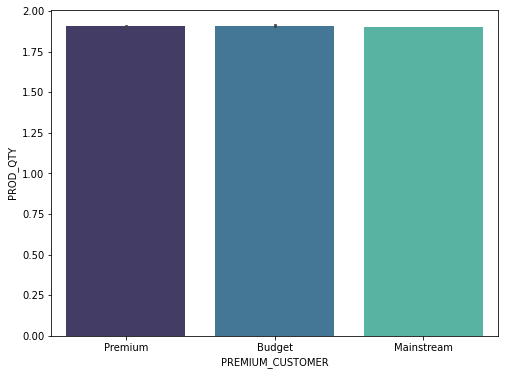

In [33]:
fig,ax = plt.subplots(figsize = (8,6))
sns.barplot(x = 'PREMIUM_CUSTOMER', y = 'PROD_QTY', data = merge_data, palette = 'mako', estimator = np.mean)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'YOUNG SINGLES/COUPLES'),
  Text(1, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(2, 0, 'NEW FAMILIES'),
  Text(3, 0, 'OLDER FAMILIES'),
  Text(4, 0, 'OLDER SINGLES/COUPLES'),
  Text(5, 0, 'RETIREES'),
  Text(6, 0, 'YOUNG FAMILIES')])

<Figure size 864x720 with 0 Axes>

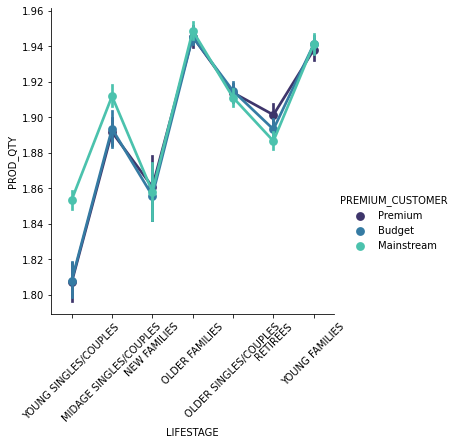

In [34]:
plt.figure(figsize=(12, 10))
ax = sns.catplot(x='LIFESTAGE',y = 'PROD_QTY',hue = 'PREMIUM_CUSTOMER',palette = 'mako',kind = 'point',data=merge_data, estimator = np.mean)
plt.xticks(rotation=45)

The product quantity per customer is a driver of total sales for mainstream young singles/couples and midage singles/couples. However, it seems not true for Mainstream - retirees, Budget - older families, and Budget - young families. Let's investigate the average price per units bought by each customer.

In [35]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  int32  
 1   STORE_NBR         246740 non-null  int32  
 2   LYLTY_CARD_NBR    246740 non-null  int32  
 3   TXN_ID            246740 non-null  int32  
 4   PROD_NBR          246740 non-null  int32  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int32  
 7   TOT_SALES         246740 non-null  float32
 8   PACK_SIZE         246740 non-null  float16
 9   BRAND_NAME        246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
dtypes: float16(1), float32(1), int32(6), object(4)
memory usage: 24.5+ MB


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'YOUNG SINGLES/COUPLES'),
  Text(1, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(2, 0, 'NEW FAMILIES'),
  Text(3, 0, 'OLDER FAMILIES'),
  Text(4, 0, 'OLDER SINGLES/COUPLES'),
  Text(5, 0, 'RETIREES'),
  Text(6, 0, 'YOUNG FAMILIES')])

<Figure size 864x720 with 0 Axes>

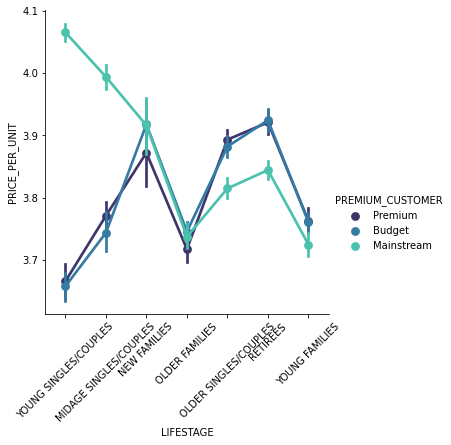

In [36]:
merge_data['PRICE_PER_UNIT'] = merge_data['TOT_SALES']/merge_data['PROD_QTY']
plt.figure(figsize=(12, 10))
ax = sns.catplot(x='LIFESTAGE',y = 'PRICE_PER_UNIT',hue = 'PREMIUM_CUSTOMER',kind = 'point',palette = 'mako',data=merge_data, estimator = np.mean)
plt.xticks(rotation=45)

Mainstream midage and young singles/couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counter parts.

As the difference in average price per unit isn't large, we can check if this difference is statiscally different.

In [37]:
mainstream_young = merge_data[(merge_data.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (merge_data.PREMIUM_CUSTOMER == 'Mainstream')]
other_young = merge_data[(merge_data.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (merge_data.PREMIUM_CUSTOMER != 'Mainstream')]
#check if we’ll assume the two populations have equal variances or not
var_ratio = np.var(mainstream_young['PRICE_PER_UNIT'])/np.var(other_young['PRICE_PER_UNIT'])

if (var_ratio <= 4) or (var_ratio >= 0.25):
    #perform two sample t-test with equal variances
    p = stats.ttest_ind(a=other_young['PRICE_PER_UNIT'], b=mainstream_young['PRICE_PER_UNIT'], equal_var=True)
print(p)

Ttest_indResult(statistic=-35.339232702326264, pvalue=1.0984957466354619e-268)


The t-test result in a p-value of 1.0984957466354619e-268, i.e. the unit price for mainstream, young singles/couples ARE significantly higher than that of budget or premium, young singles and couples

In [38]:
mainstream_midage = merge_data[(merge_data.LIFESTAGE == 'MIDAGE SINGLES/COUPLES') & (merge_data.PREMIUM_CUSTOMER == 'Mainstream')]
other_midage = merge_data[(merge_data.LIFESTAGE == 'MIDAGE SINGLES/COUPLES') & (merge_data.PREMIUM_CUSTOMER != 'Mainstream')]
#check if we’ll assume the two populations have equal variances or not
var_ratio = np.var(mainstream_midage['PRICE_PER_UNIT'])/np.var(other_midage['PRICE_PER_UNIT'])

if (var_ratio <= 4) or (var_ratio >= 0.25):
    #perform two sample t-test with equal variances
    p = stats.ttest_ind(a=other_midage['PRICE_PER_UNIT'], b=mainstream_midage['PRICE_PER_UNIT'], equal_var=True)
print(p)

Ttest_indResult(statistic=-16.814983048522055, pvalue=4.449933979429101e-63)


The t-test result in a p-value of 4.449933979429101e-63, i.e. the unit price for mainstream, midage singles/couples are significantly higher than that of budget or premium, midage singles and couples

We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at mainstream, young single/couples. Let's find out if they tend to buy a particular brand of chips.

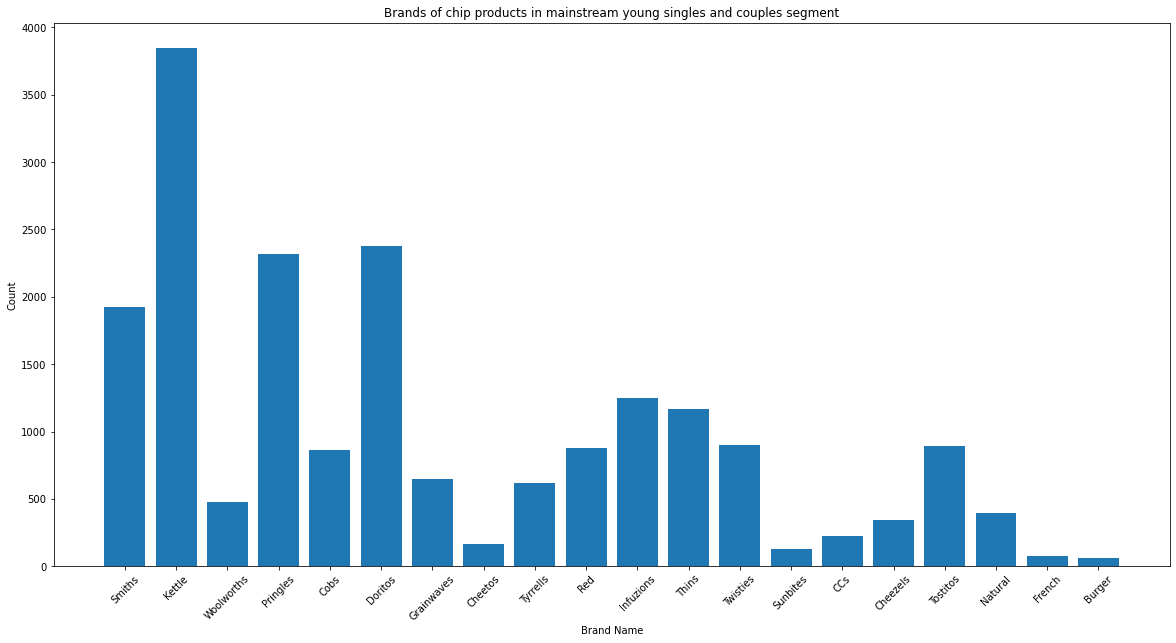

In [39]:
top = Counter(mainstream_young['BRAND_NAME'])
top_brands = Counter(mainstream_young['BRAND_NAME']).keys()
top_counts = Counter(mainstream_young['BRAND_NAME']).values()


#Plot the bar chart
ax,fig = plt.subplots(figsize=(20,10))
plt.bar(top_brands, top_counts)
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.title('Brands of chip products in mainstream young singles and couples segment')
plt.xticks(rotation=45)
plt.show()

Mainstream young customers tend to buy Kettle, Doritos, and Pringles chips. Let's perform a-priori analysis to find out what brands this customer segments usually buy with each other.

In [40]:
mainstream_young_pivot = mainstream_young.loc[:, ['LYLTY_CARD_NBR', 'BRAND_NAME'] ]
#add new column with constant value 1
mainstream_young_pivot['VALUES'] = mainstream_young_pivot.apply(lambda x: 1, axis = 1)

#Reshape data to pivot form
pivot = pd.pivot_table(mainstream_young_pivot,index = 'LYLTY_CARD_NBR',columns='BRAND_NAME',values = 'VALUES')


In [41]:
pivot.head()

BRAND_NAME,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grainwaves,Infuzions,Kettle,Natural,Pringles,Red,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1060,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN


We need to remove these NaN and replace by 0.

In [42]:
pivot = pivot.fillna(0)
pivot.head()

BRAND_NAME,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grainwaves,Infuzions,Kettle,Natural,Pringles,Red,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1010,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1060,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [43]:
#Run apriori algo
frequent_itemsets = apriori(pivot, min_support = 0.035, use_colnames = True)
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Infuzions),(Pringles),0.143110,0.256158,0.041051,0.286849,1.119815,0.004392,1.043036
7,(Thins),(Pringles),0.136036,0.256158,0.037388,0.274838,1.072923,0.002541,1.025760
3,(Thins),(Doritos),0.136036,0.260326,0.037388,0.274838,1.055744,0.001974,1.020012
0,(Infuzions),(Doritos),0.143110,0.260326,0.037388,0.261253,1.003563,0.000133,1.001255
5,(Pringles),(Infuzions),0.256158,0.143110,0.041051,0.160256,1.119815,0.004392,1.020419
6,(Pringles),(Thins),0.256158,0.136036,0.037388,0.145957,1.072923,0.002541,1.011616
2,(Doritos),(Thins),0.260326,0.136036,0.037388,0.143620,1.055744,0.001974,1.008855
1,(Doritos),(Infuzions),0.260326,0.143110,0.037388,0.143620,1.003563,0.000133,1.000595


Interpret and explanation: 
- There are 2 parts: antecedents and consequents. Means if a customer buy antecedents then same person may buy consequents
- Support = occurrentce of item / total transactions. Let's consider the first row in the rules table above. Antecedent support means support for Red and Consequent support means support for Smiths. Support (5th column) means support for Red and Smiths
- Confidence = (Support for items bought together )/( Support for items bought as separately ). So if item bought together is less than bought single times then occurrence may be insignificant 
- Lift: indicates strength of any rule. For example, we derrived that Red and Smiths chips are bought together but how strong association is this? So higher Lift indicates higher chances of buying these items together than individual

From the table above, we can extract the item that mainstream young customers bought together:
- Red and Smiths
- Infuzions and Pringles
- Thins and Doritos
- Infuzions and Doritos
- Pringles and Infuzions
- Pringles and Thins

Let's dive into the pack size for this customer segment!

C:\Users\workt\AppData\Local\Temp/ipykernel_12264/3483001946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainstream_young['PACK_SIZE'] = mainstream_young['PACK_SIZE'].astype('str')


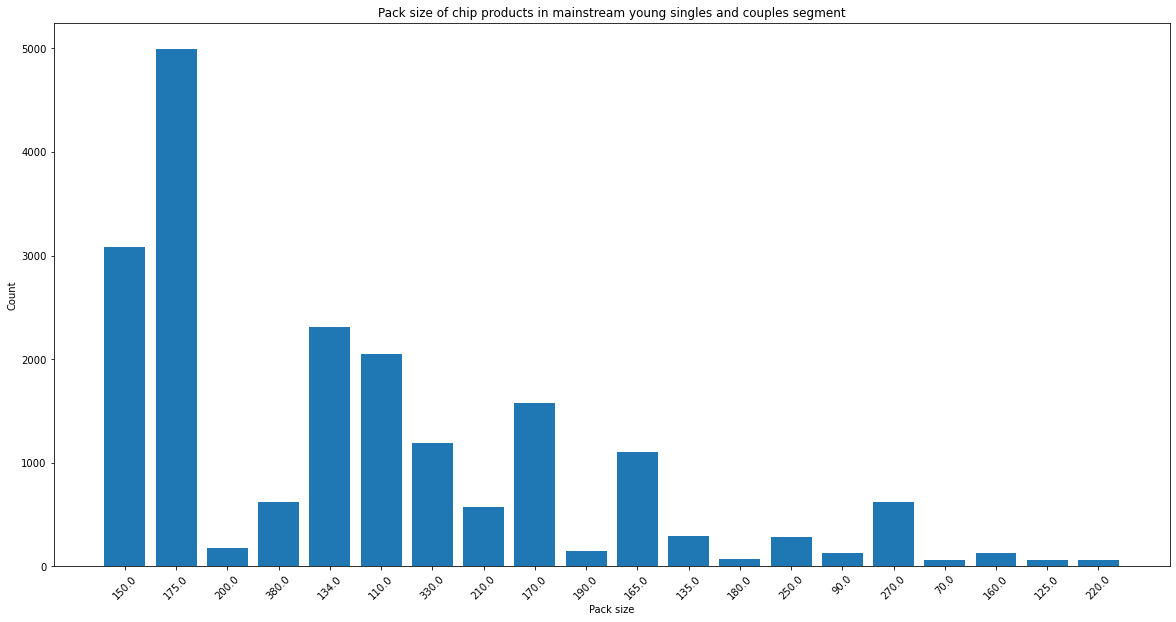

In [44]:
mainstream_young['PACK_SIZE'] = mainstream_young['PACK_SIZE'].astype('str')
top = Counter(mainstream_young['PACK_SIZE'])
top_brands = Counter(mainstream_young['PACK_SIZE']).keys()
top_counts = Counter(mainstream_young['PACK_SIZE']).values()


#Plot the bar chart
ax,fig = plt.subplots(figsize=(20,10))
plt.bar(top_brands, top_counts)
plt.xlabel('Pack size')
plt.ylabel('Count')
plt.title('Pack size of chip products in mainstream young singles and couples segment')
plt.xticks(rotation=45)
plt.show()

From the graph, the popular pack size 150g and 175g for mainstream young customer.